## Brent Oil Price Time Series Analysis

This notebook performs exploratory data analysis and time series diagnostics on historical Brent oil prices.  
The goal is to understand key properties of the data—trend, stationarity, and volatility—before applying Bayesian change point models.

### Imports and loading datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

plt.rcParams["figure.figsize"] = (12, 6)


In [2]:
import pandas as pd

# Load Brent prices CSV (path is relative to the notebook)
# File contains mixed date formats (e.g., '20-May-87' and 'Apr 22, 2020')
df = pd.read_csv("../data/raw/BrentOilPrices.csv")

# Keep original strings for debugging
orig_dates = df["Date"].copy()

# Parse with inference to handle mixed formats; report any failures
# Note: some pandas versions don't accept `infer_datetime_format` keyword
try:
    df["Date"] = pd.to_datetime(orig_dates, dayfirst=False, errors='coerce')
except TypeError:
    df["Date"] = pd.to_datetime(orig_dates, errors='coerce')

if df["Date"].isna().any():
    bad = orig_dates[df["Date"].isna()].head(10).tolist()
    raise ValueError(f"Failed to parse these date strings (examples): {bad}")

# Sort chronologically
df = df.sort_values("Date").reset_index(drop=True)

df.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_9884\24439821.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(orig_dates, dayfirst=False, errors='coerce')


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


### Data Inspection

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9011 non-null   datetime64[us]
 1   Price   9011 non-null   float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 140.9 KB


In [4]:
# Check for missing values
df.isna().sum()

Date     0
Price    0
dtype: int64

## Step 4: Event Data Integration

To interpret structural changes in Brent oil prices, we incorporate a curated list of major geopolitical, economic, and OPEC-related events.

These events are **not used directly in modeling at this stage**, but are essential for:
- Contextual interpretation of price movements
- Hypothesis generation for detected change points
- Linking statistical findings to real-world phenomena


In [5]:
import os

# Prefer processed events file; fall back to raw events.csv if missing
events_path = "../data/raw/events.csv"
if os.path.exists(events_path):
    events = pd.read_csv(events_path)
else:
    events = pd.read_csv("../data/raw/events.csv")

# Convert event start dates to datetime
events["start_date"] = pd.to_datetime(events["start_date"], errors='coerce')

# show a small sample
events.head()

,event_id,event_name,event_type,start_date,description
0,1,Global Financial Crisis,Economic Shock,2008-09-15,Collapse of major financial institutions leadi...
1,2,Arab Spring Uprisings,Geopolitical Conflict,2011-01-25,Political instability across Middle East and N...
2,3,Libyan Civil War,Geopolitical Conflict,2011-02-15,Major disruption in Libyan oil production
3,4,OPEC Production Surge,OPEC Policy,2014-11-27,OPEC decision not to cut production leading to...
4,5,US Shale Boom,Technological/Economic,2014-01-01,Rapid increase in US shale oil production incr...


### Event Coverage

The event dataset spans major global oil market disruptions, including:
- Geopolitical conflicts
- OPEC policy decisions
- Economic crises
- Sanctions and supply shocks

This ensures broad coverage of potential drivers of regime changes in oil prices.


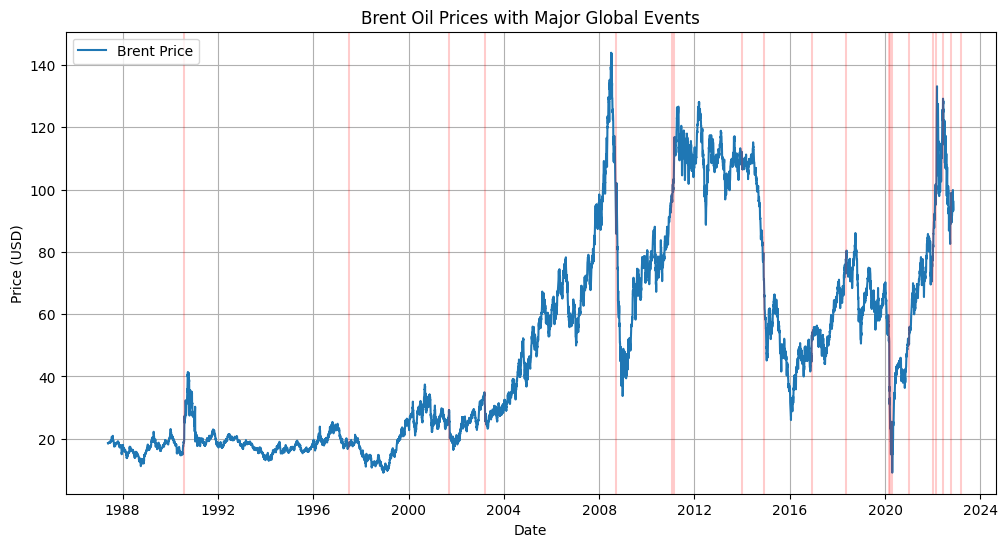

In [6]:
plt.plot(df["Date"], df["Price"], label="Brent Price")

# Plot event markers
for _, row in events.iterrows():
    plt.axvline(row["start_date"], color="red", alpha=0.2)

plt.title("Brent Oil Prices with Major Global Events")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


## Events and Statistical Modeling

While major events are visually aligned with price movements, they are **not directly encoded** into the statistical model at this stage.

Reasons:
- Event timing is often approximate
- Markets may react before or after official dates
- Multiple events may overlap in time

Therefore, events are used for **interpretive analysis**, while change point detection is performed using price data alone.

This approach avoids forcing causal assumptions and maintains statistical integrity.


## Role of Events in Change Point Analysis

In the next stage of analysis:
- Bayesian change point models will identify statistically significant regime shifts
- Detected change points will be compared against this event dataset
- Hypotheses will be formulated about which events may have contributed to each shift

This separation ensures a clear distinction between **statistical detection** and **economic interpretation**.


## Step 2: Exploratory Data Analysis (EDA)

We visualize the raw Brent oil price series to identify:
- Long-term trends
- Sudden price shocks
- Periods of heightened volatility

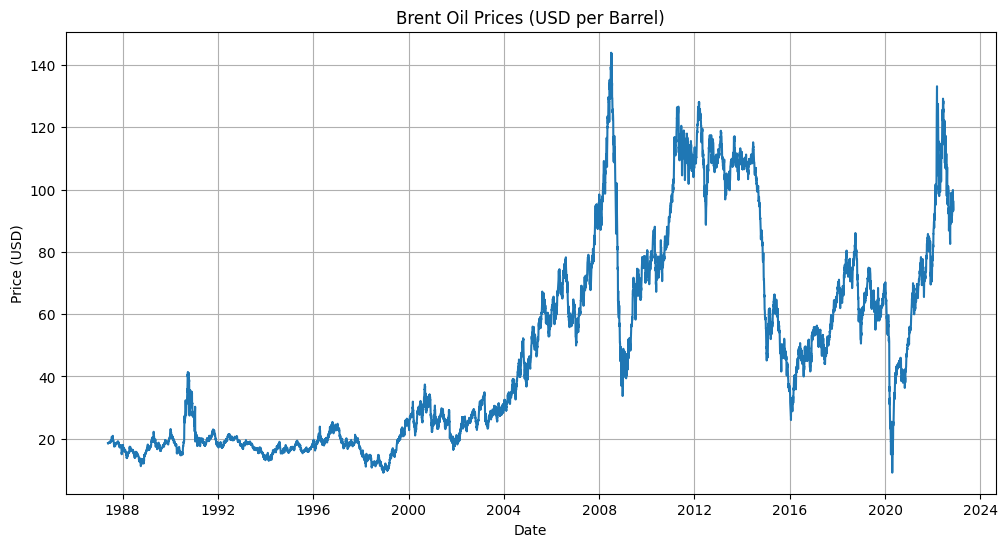

In [7]:
# Plot Raw Price Series

plt.plot(df["Date"], df["Price"])
plt.title("Brent Oil Prices (USD per Barrel)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()


### Log Returns Transformation

Since oil prices are non-stationary, we compute log returns to stabilize variance and improve stationarity.


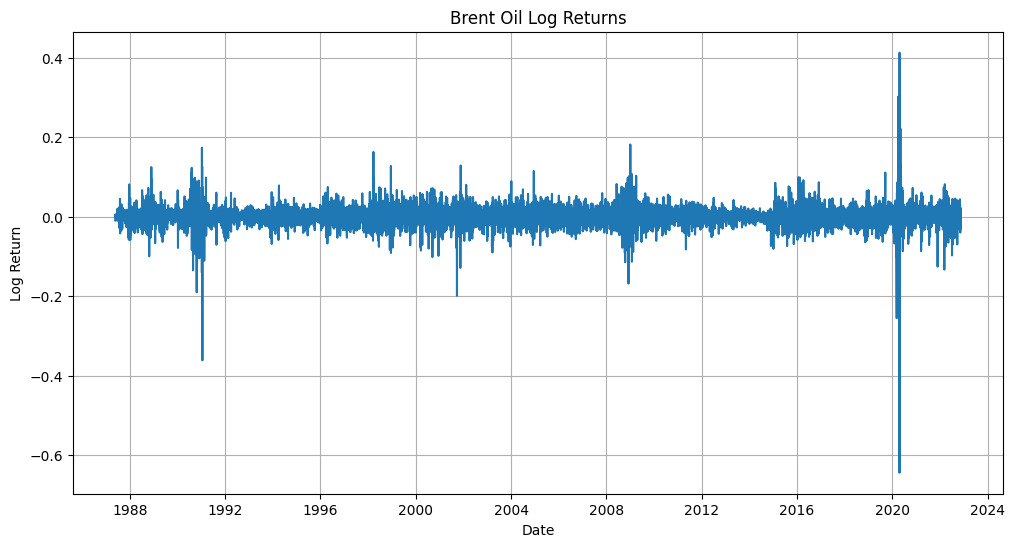

In [8]:
# Compute Log Returns
df["log_price"] = np.log(df["Price"])
df["log_return"] = df["log_price"].diff()

df.dropna(inplace=True)
df.head()
# Visualizations
plt.plot(df["Date"], df["log_return"])
plt.title("Brent Oil Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()


## Step 3: Time Series Diagnostics

We analyze key statistical properties of the series:
- Trend behavior
- Stationarity
- Volatility patterns


### Augmented Dickey-Fuller (ADF) Test

The ADF test evaluates whether a time series is stationary.
- Null hypothesis: Series has a unit root (non-stationary)
- Alternative hypothesis: Series is stationary


In [9]:
# ADF Test on Price Levels
adf_price = adfuller(df["Price"])

print("ADF Statistic (Price):", adf_price[0])
print("p-value:", adf_price[1])


ADF Statistic (Price): -1.9918544071295257
p-value: 0.29015603926422134


In [10]:
adf_returns = adfuller(df["log_return"])

print("ADF Statistic (Log Returns):", adf_returns[0])
print("p-value:", adf_returns[1])


ADF Statistic (Log Returns): -16.427113494485894
p-value: 2.4985801611428892e-29


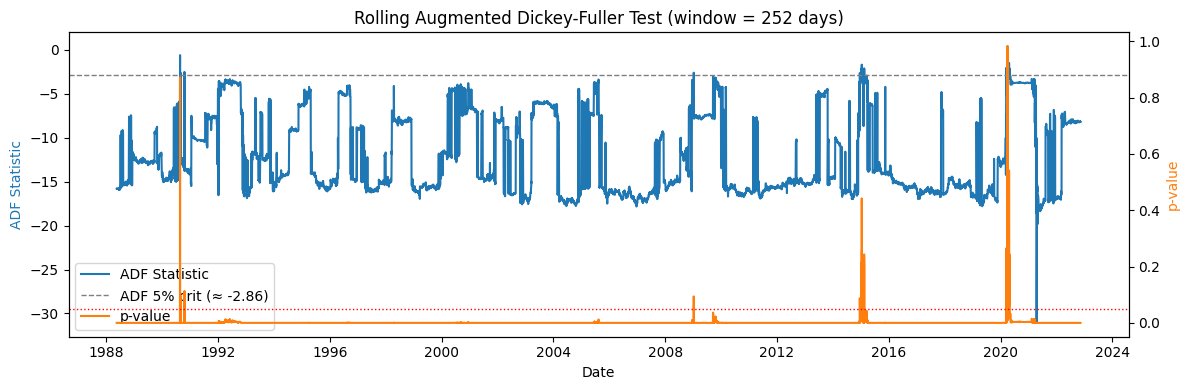

In [11]:
# Rolling ADF test and plot
import numpy as np
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Ensure log returns exist and align dates/returns by dropping NaNs
if 'log_return' not in df.columns:
    df['log_return'] = np.log(df['Price']).diff()

mask = df['log_return'].notna()
returns = df.loc[mask, 'log_return'].reset_index(drop=True)
dates = df.loc[mask, 'Date'].reset_index(drop=True)

# Rolling window size (days) — adjust as needed (e.g., 252 trading days ~ 1 year)
window = 252
if len(returns) < window * 2:
    window = max(30, len(returns) // 4)

adf_stats = []
adf_pvals = []
adf_dates = []

# Compute rolling ADF on trailing window ending at each index
for end in range(window, len(returns)):
    window_series = returns.iloc[end - window : end]
    try:
        res = adfuller(window_series, autolag='AIC')
        stat, pval = res[0], res[1]
    except Exception:
        stat, pval = np.nan, np.nan
    adf_stats.append(stat)
    adf_pvals.append(pval)
    # label with the last date in the window
    adf_dates.append(dates.iloc[end - 1])

# Convert to arrays/series
adf_stats = np.array(adf_stats)
adf_pvals = np.array(adf_pvals)

# Plot ADF statistic and p-value
fig, ax1 = plt.subplots(figsize=(12,4))
ax2 = ax1.twinx()

ax1.plot(adf_dates, adf_stats, color='tab:blue', label='ADF Statistic')
ax2.plot(adf_dates, adf_pvals, color='tab:orange', label='p-value')

ax1.axhline(y=-2.86, color='tab:gray', linestyle='--', linewidth=1, label='ADF 5% crit (≈ -2.86)')

ax1.set_xlabel('Date')
ax1.set_ylabel('ADF Statistic', color='tab:blue')
ax2.set_ylabel('p-value', color='tab:orange')
ax1.set_title('Rolling Augmented Dickey-Fuller Test (window = {} days)'.format(window))

ax2.axhline(y=0.05, color='red', linestyle=':', linewidth=1)

# format x axis
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

# legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.tight_layout()
plt.show()


### Volatility Patterns

We examine rolling volatility to detect volatility clustering and regime changes.

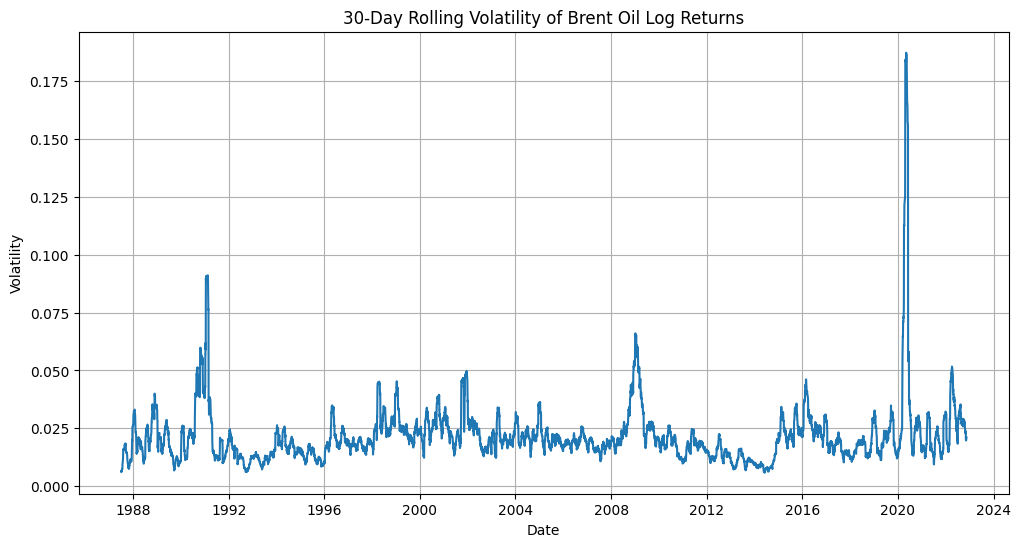

In [12]:
# Rolling Volatility
rolling_vol = df["log_return"].rolling(window=30).std()

plt.plot(df["Date"], rolling_vol)
plt.title("30-Day Rolling Volatility of Brent Oil Log Returns")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()


## Conclusion

- Loaded and cleaned daily Brent prices (~9k rows) and a curated events catalog.
- Fixed mixed-format date parsing, computed `log_return`, and aligned data for analysis.
- Produced price and log-return plots and a 30‑day rolling volatility series.
- ADF tests: price levels are non‑stationary (ADF ≈ -1.99, p ≈ 0.29); log returns are stationary.
- Rolling ADF shows stationarity fluctuates over time, often around crisis periods; volatility spikes align with major events.

Next steps: persist processed data to `data/processed/` and move repeatable logic into `src/` for reuse.